In [5]:
import random
from time import time
import cvxpy as cvx
from tqdm import tqdm_notebook as tqdm
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from scipy.sparse import linalg

%matplotlib inline

In [2]:
features, targets = load_svmlight_file('usps')
targets = np.array(list(map(int, targets))) - 1
features = np.array(features.todense())

num_examples, feature_dim = features.shape


In [4]:
def f_i(features, targets, w, i):
    target_i = targets[i]
    return np.log(np.sum(np.exp(w@features[i]))) - w[target_i]@features[i]
    
def result_function(features, targets, w):
    loss = 0
    n_examples = targets.shape[0]
    for i in range(n_examples):
        loss += f_i(features, targets, w, i)
    return loss/n_examples

def grad_i(features, targets, w, i):
    exp = np.exp(w@features[i].T)
    grad = np.outer(exp/np.sum(exp),features[i])
    grad[targets[i]] -= - features[i]
    return grad    

def grad(features, targets, w, stochastic=False, batch_size=50):
    n_examples = targets.shape[0]
    gradient = np.zeros_like(w)
    if stochastic:
        rand_index = np.random.randint(0, n_examples-1, size=batch_size)
        for i in rand_index:
            gradient += grad_i(features, targets, w, i)
        return gradient/batch_size
    else:
        for i in range(n_examples):
            gradient += grad_i(features, targets, w, i)
        return gradient/n_examples

In [6]:
def simplex_projection(s,R=50):
    if np.sum(s) <= R and np.alltrue(s >= 0):
        return s
    # Code taken from https://gist.github.com/daien/1272551
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    try:
        rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - R))[0][-1]
    except IndexError:
        rho = 0
    theta = (cssv[rho] - R) / (rho + 1.)
    return np.maximum(s-theta, 0)

def nuclear_projection(A,R=50):
    U, s, V =  np.linalg.svd(A, full_matrices=False)
    s = simplex_projection(s,R)
    return U.dot(np.diag(s).dot(V))

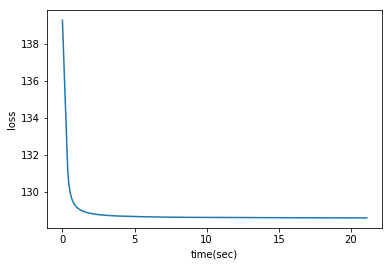

In [8]:
n_k = 0.1
w = np.load('losses/w.npy')[0]
loss = result_function(features, targets, w)
losses = [loss]
step = 0
times = [0]
start_time=time()
        
for total_step in tqdm(range(5)):
    w_0 = w
    snapshot_grad = grad(features, targets, w_0)
    
    for _ in tqdm(range(50)):
        step += 1
        
        gradient = np.zeros_like(w)
        gradient_w_0 = np.zeros_like(w)
        for _ in range(50):
            rand_index = np.random.randint(0, targets.shape[0]-1)
            gradient += grad_i(features, targets, w, rand_index)
            gradient_w_0 += grad_i(features, targets, w_0, rand_index)
            
        gradient /= 50
        gradient_w_0/= 50
        
        total_gradient = gradient - gradient_w_0 + snapshot_grad
        n_k = 0.1/step**2
        w = w - n_k*total_gradient
        w = nuclear_projection(w)

        loss = result_function(features, targets, w)
        losses.append(loss)
        times.append(round(time() - start_time, 2))
        
plt.plot(times,losses, label='SVRG')
plt.xlabel('time(sec)')
plt.ylabel('loss')
plt.show()

In [9]:
np.save('losses/losses_reSGD', losses)
np.save('losses/times_reSGD', times)